# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
#импортируем нужные библиотеки
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv' , sep='\t')
    
except:
    data = pd.read_csv('/datasets/real_estate_data.csv' , sep='\t')


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


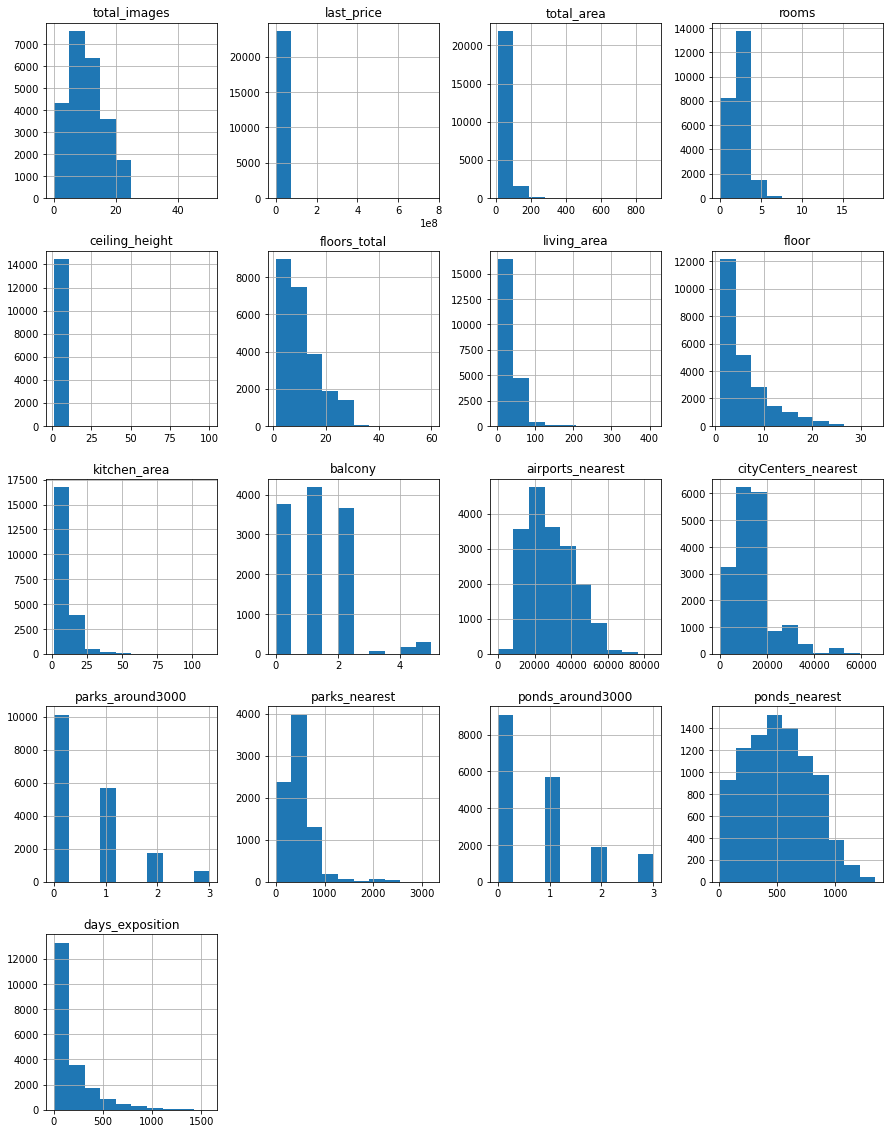

In [5]:
data.hist(figsize=(15, 20))
plt.show()

Вывод
Данные по last_price , total_area , rooms, ceiling_height, kitchen_area довольно сильно разбросаны, возможно по ним нужно будет исключить "выбросы"

### Предобработка данных

In [6]:
# считаем пропуски
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [7]:
# Заполняем пропуски
# Для балконов - можем заполнить нулями, скорее всего их просто нет
# Для высоты потолков заполним медианным значением, чтобы не исказить общую картину
# Если не указано кол-во этажей - заполним этажом из объявления
data['balcony'] = data['balcony'].fillna('0')
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['floors_total'] = data['floors_total'].fillna(data['floor'])
# для площади кухни: пропишим если свободная планировка и это студия - заполним площадь кухни нулями
cond = (data['open_plan'] == True) | (data['studio'] == True)
data.loc[cond, 'kitchen_area'] = data.loc[cond, 'kitchen_area'].fillna(0)

In [8]:
# проверяем заполнены ли пропуски
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2062
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Остальные пропуски стоит оставить без изменений 

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21637 non-null  float64
 13  balcony               23699 non-null  object 
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [10]:
# Кол-во этажей и балконов переведем в целые числа , так как они не могут был нецелыми
# Дату публикации переведем в формат даты 
data['floors_total'] = data['floors_total'].astype('int64')
data['balcony'] = data['balcony'].astype('int64')
data['first_day_exposition']= pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')

In [11]:
# Проверяем написание поселка
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [12]:
# создаем переменную, в которую добавим все значения, которые хотим заменить
# пишем цикл для замены
to_replace = ['посёлок', 'посёлок городского типа', 'поселок городского типа', 'городской посёлок', 'городской поселок', 'поселок при железнодорожной станции', 'поселок станции']
for substr in to_replace:
  data['locality_name'] = data['locality_name'].str.replace(substr, 'поселок')

In [13]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок Красный Бор', 'Гатчина', 'деревня Фёдоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'поселок Металлострой', 'поселок Лебяжье', 'поселок Сиверский',
       'поселок Молодцово', 'поселок Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок Ефимовский', 'поселок Плодовое', 'деревня Заклинье',
       'поселок Торковичи', 'поселок Первомайское', 'Красное Село',
       'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       'Никольское', 'Зелено

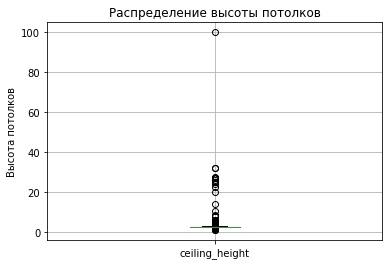

In [14]:
data.boxplot('ceiling_height')
plt.title("Распределение высоты потолков")
plt.ylabel("Высота потолков")
plt.show()


In [15]:
# высота потолка 100м кажется аномалией
data['ceiling_height'].max()

100.0

In [16]:
# заменим значения больше 20,значениями поделенными на 10
data.loc[data['ceiling_height']>20, 'ceiling_height'] = data.loc[data['ceiling_height']>20, 'ceiling_height'] / 10

In [17]:
data['ceiling_height'].max()

20.0

In [18]:
# Так же стоит ограничить по цене
# Вызову дискрайб чтобы проверить как ограничение повляет на count , mean и остальные показатели

data.query('last_price <= 20000000').describe().round(0)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,22992.0,22992.0,22992.0,22992.0,22992.0,22992.0,21184.0,22992.0,21010.0,22992.0,17472.0,17489.0,17490.0,7574.0,17490.0,8594.0,20008.0
mean,10.0,5423607.0,57.0,2.0,3.0,11.0,33.0,6.0,10.0,1.0,28852.0,14495.0,1.0,494.0,1.0,524.0,178.0
std,6.0,3220160.0,25.0,1.0,0.0,7.0,17.0,5.0,5.0,1.0,12793.0,8577.0,1.0,342.0,1.0,277.0,216.0
min,0.0,12190.0,12.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,208.0,0.0,1.0,0.0,13.0,1.0
25%,6.0,3400000.0,40.0,1.0,3.0,5.0,18.0,2.0,7.0,0.0,18427.0,9815.0,0.0,289.0,0.0,303.0,44.0
50%,9.0,4550000.0,51.0,2.0,3.0,9.0,30.0,4.0,9.0,0.0,26820.0,13277.0,0.0,456.0,0.0,510.0,94.0
75%,14.0,6500000.0,67.0,3.0,3.0,16.0,41.0,8.0,12.0,1.0,37434.0,16464.0,1.0,614.0,1.0,734.0,227.0
max,50.0,20000000.0,461.0,11.0,20.0,60.0,280.0,33.0,101.0,5.0,84869.0,65968.0,3.0,3190.0,3.0,1344.0,1580.0


In [19]:
data.describe().round(0)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.0,23699.0,23699.0,23699.0,23699.0,23699.0,21796.0,23699.0,21637.0,23699.0,18157.0,18180.0,18181.0,8079.0,18181.0,9110.0,20518.0
mean,10.0,6541549.0,60.0,2.0,3.0,11.0,34.0,6.0,10.0,1.0,28794.0,14191.0,1.0,491.0,1.0,518.0,181.0
std,6.0,10887013.0,36.0,1.0,0.0,7.0,22.0,5.0,6.0,1.0,12631.0,8608.0,1.0,342.0,1.0,278.0,220.0
min,0.0,12190.0,12.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,181.0,0.0,1.0,0.0,13.0,1.0
25%,6.0,3400000.0,40.0,1.0,3.0,5.0,19.0,2.0,7.0,0.0,18585.0,9238.0,0.0,288.0,0.0,294.0,45.0
50%,9.0,4650000.0,52.0,2.0,3.0,9.0,30.0,4.0,9.0,0.0,26726.0,13098.0,0.0,455.0,1.0,502.0,95.0
75%,14.0,6800000.0,70.0,3.0,3.0,16.0,42.0,8.0,12.0,1.0,37273.0,16293.0,1.0,612.0,1.0,729.0,232.0
max,50.0,763000000.0,900.0,19.0,20.0,60.0,410.0,33.0,112.0,5.0,84869.0,65968.0,3.0,3190.0,3.0,1344.0,1580.0


In [20]:
# ТАкое условие не искажает данные, показатели по цене становятся более "реалистичными"
data = data.query('last_price <= 20000000')

Мы обработали высоту потолков, и выбрали объявления с ценой менее 20000000, данные стали более органичными.

In [21]:
# добавляем новый столбец, вытаскиваем в отдельный столбец день недели,месяц , год
data['price_per_q'] =data['last_price'] / data['total_area']
data ['day_of_week'] = data['first_day_exposition'].dt.weekday
data ['month'] = data['first_day_exposition'].dt.month
data ['year'] = data['first_day_exposition'].dt.year


In [22]:
# Пишем функцию для определения типа этажа
def floor_categ(f):
    if f['floor'] == 1:
        return 'первый'
    if f['floor'] == f['floors_total'] and f['floor'] != 1:
        return 'последний'
    else : 
        return 'другой'

# применяем к новому столбцу
data['floor_category'] = data.apply(floor_categ, axis = 1)

# проверяем как она сработала
data.groupby('floor_category').count()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_q,day_of_week,month,year
floor_category,,,,,,,,,,,,,,,,,,,,,
другой,16839,16839,16839,16839,16839,16839,16839,15549,16839,1997,...,13267,13268,5499,13268,6457,14773,16839,16839,16839,16839
первый,2878,2878,2878,2878,2878,2878,2878,2630,2878,321,...,1962,1962,949,1962,957,2446,2878,2878,2878,2878
последний,3275,3275,3275,3275,3275,3275,3275,3005,3275,374,...,2260,2260,1126,2260,1180,2789,3275,3275,3275,3275


In [23]:
# переводим в км, округляем до целого
data['cityCenters_nearest'] = round(data['cityCenters_nearest'] / 1000 , 0)

Категории в будущем позволят проверить, как этажность влияет на цену.
Интересно, где предпочитают жить петербуржцы...

### Исследовательский анализ данных

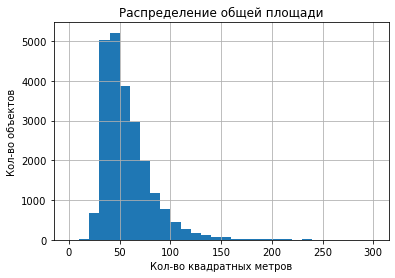

In [24]:
#Общая площадь
data['total_area'].hist(bins = 30 , range=(0, 300)).set_title('sepal length')


plt.title("Распределение общей площади")
plt.ylabel("Кол-во объектов")
plt.xlabel("Кол-во квадратных метров")
plt.show()

Мы видим распределение Паусона,наибольшее число квартир имеет общую площадь от 25 до 50. Квартир с метражом более 100 м крайне мало, по сравнению с остальной выборкой

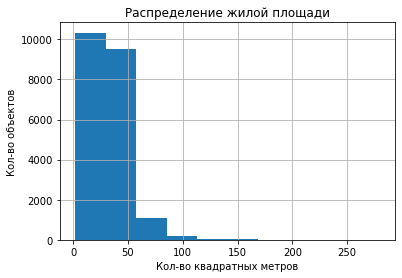

In [25]:
#жилая площадь
data['living_area'].hist(bins = 10 )
plt.title("Распределение жилой площади")
plt.ylabel("Кол-во объектов")
plt.xlabel("Кол-во квадратных метров")
plt.show()

Жилая площадь в большинстве квартир до 50 кв.м.

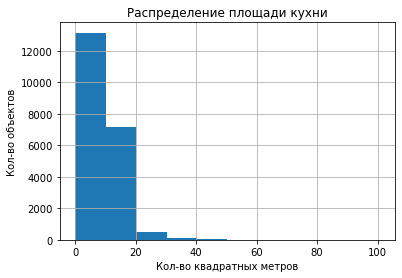

In [26]:
#площадь кухни
data['kitchen_area'].hist(bins = 10)
plt.title("Распределение площади кухни")
plt.ylabel("Кол-во объектов")
plt.xlabel("Кол-во квадратных метров")
plt.show()

Кухни, в основном, идут до 20 кв.м.

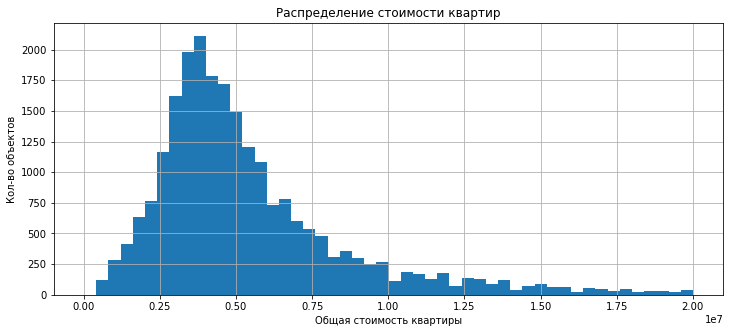

In [27]:
#цена объекта
data['last_price'].hist(bins = 50 , figsize=(12, 5))
plt.title("Распределение стоимости квартир")
plt.ylabel("Кол-во объектов")
plt.xlabel("Общая стоимость квартиры")
plt.show()

Наибольше число квартир по цене находятся в диапозоне от 2.5 млн до 5 млн . 

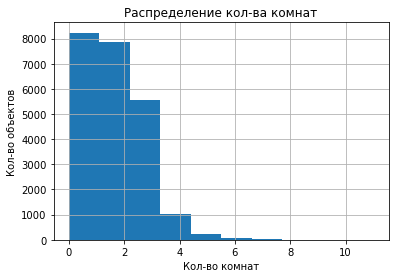

In [28]:
#кол-во комнат
data['rooms'].hist(bins = 10)
plt.title("Распределение кол-ва комнат")
plt.ylabel("Кол-во объектов")
plt.xlabel("Кол-во комнат")
plt.show()

В основном на рынке представлены квартиры студии и до двух комнат.

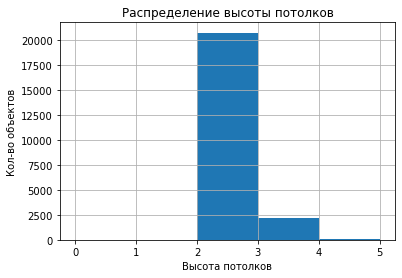

In [29]:
data['ceiling_height'].hist(bins = 5 , range=(0, 5))
plt.title("Распределение высоты потолков")
plt.ylabel("Кол-во объектов")
plt.xlabel("Высота потолков")
plt.show()

Высота потолков имеет не такой сильный разброс, как остальные данные. У большинства квартир это от 2 до 3 метров. Тем не менее не стоит забывать, что мы обрабатывали эти значения, возможно это сильно повлияло на данные.

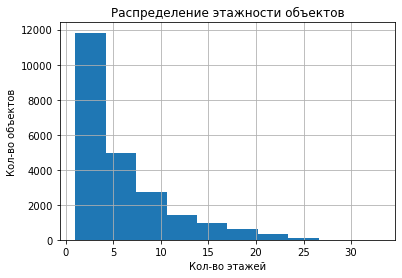

In [30]:
data['floor'].hist(bins = 10)
plt.title("Распределение этажности объектов")
plt.ylabel("Кол-во объектов")
plt.xlabel("Кол-во этажей")
plt.show()

Приемущественно в городе высталены квартиры до 10 этажа. Это логично и не противоречит логике - в Петербурге нет высотной застройки.

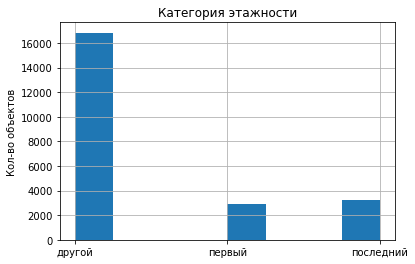

In [31]:
data['floor_category'].hist(bins = 8)
plt.title("Категория этажности")
plt.ylabel("Кол-во объектов")

plt.show()

Категоризация данных - позволила нам разделить на три группы. В основном квартиры находятся не на первом и не на последнем этаже.Отличие первого от последнего этажа не стоит считать значимым. Так как по некоторым пропускам мы заполняли последний этаж как этаж из объявления.

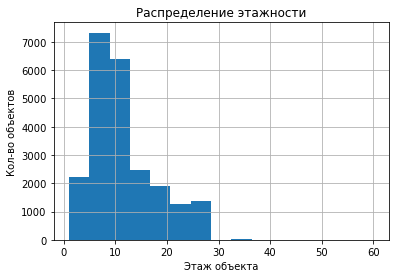

In [32]:
data['floors_total'].hist(bins = 15)
plt.title("Распределение этажности")
plt.ylabel("Кол-во объектов")
plt.xlabel("Этаж объекта")
plt.show()

Большинство домов из объявлений низкоэтажные : до 15 этажей.

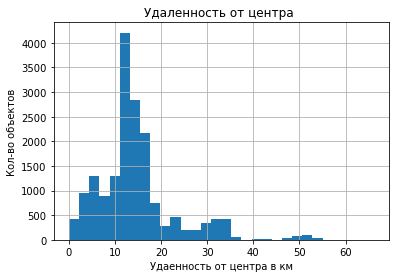

In [33]:
data['cityCenters_nearest'].hist(bins = 30)
plt.title("Удаленность от центра ")
plt.ylabel("Кол-во объектов")
plt.xlabel("Удаенность от центра в км")
plt.show()

Квартиры в основном удалены от центра города на расстоянии от 10 км до 20.

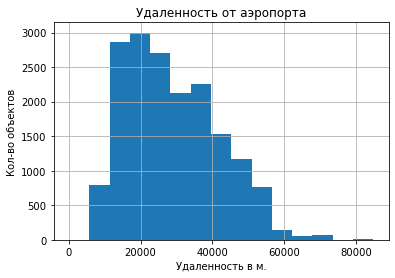

In [34]:
data['airports_nearest'].hist(bins = 15)
plt.title("Удаленность от аэропорта")
plt.ylabel("Кол-во объектов")
plt.xlabel("Удаленность в м.")
plt.show()

Объектов непосредственно у аэропорта нет - как и в большинстве городов аэропорт удален от городских улиц.
Большинство объектов достаточно удалены от аэропорта, как минимум на 20км.

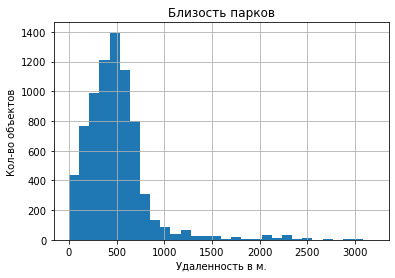

In [35]:
data['parks_nearest'].hist(bins = 30)
plt.title("Близость парков")
plt.ylabel("Кол-во объектов")
plt.xlabel("Удаленность в м.")
plt.show()

Заметно, что пик находится на уровне 1400 шт,тем не менее значений в таблице гораздно больше. По многим объектам просто нет данных
По объектам недвижимости, где есть данные, в основном есть парк, в 500 метрах от объекта.

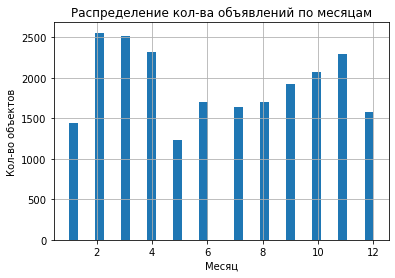

In [36]:
data['month'].hist(bins = 35)
plt.title("Распределение кол-ва объявлений по месяцам")
plt.ylabel("Кол-во объектов")
plt.xlabel("Месяц")
plt.show()

По месяцам данные распределены неравномерно, чаще всего объявления выставляют в феврале,марте,апреле и ноябре.

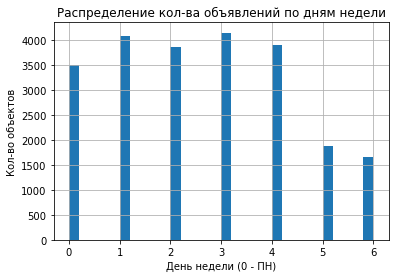

In [37]:
data['day_of_week'].hist(bins = 30)
plt.title("Распределение кол-ва объявлений по дням недели")
plt.ylabel("Кол-во объектов")
plt.xlabel("День недели (0 - ПН)")
plt.show()

По дням недели очевидно : чаще всего выставляют объявления по будням.

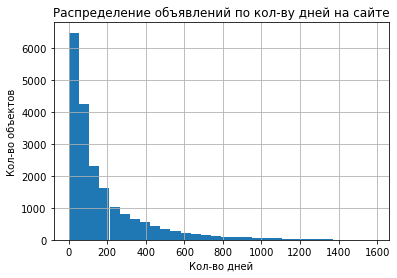

In [38]:
data['days_exposition'].hist(bins = 30)
plt.title("Распределение объявлений по кол-ву дней на сайте")
plt.ylabel("Кол-во объектов")
plt.xlabel("Кол-во дней")
plt.show()

In [39]:
data['days_exposition'].median()

94.0

In [40]:
data['days_exposition'].mean()

177.84276289484205

Построим график, указав в корзины числа кратные месяцу, для наглядности

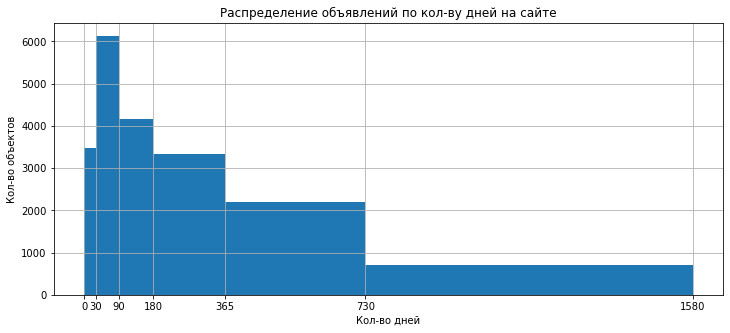

In [41]:
bins = [0, 30, 90, 180, 365, 730, data['days_exposition'].max()]
data['days_exposition'].hist(figsize=(12, 5), bins=bins)
plt.title("Распределение объявлений по кол-ву дней на сайте")
plt.ylabel("Кол-во объектов")
plt.xlabel("Кол-во дней")
plt.xticks(bins);

Как мы видим, спустя 90 дней новый объект находит своего покупателя чаще всего, это же подтверждает медианное значени : 94 дня. Тем не менее, большое кол-во объявлений остаются актуальными и год и два.
С уверенностью можно утверждать, что быстрыми продажами можно назвать объявления,которые провели на сайте менее 90 дней. К необычно долгим объявлениям я бы отнес объекты, которые находились на сайте больше 730 дней - их менее тысячи.

In [42]:
# Считаем коэф коррекляци для наших столбцов(исключая категорийные)
print(data['last_price'].corr(data['total_area']))
print(data['last_price'].corr(data['living_area']))
print(data['last_price'].corr(data['kitchen_area']))
print(data['last_price'].corr(data['rooms']))
print()
print(data['last_price'].corr(data['day_of_week']))
print(data['last_price'].corr(data['month']))
print(data['last_price'].corr(data['year']))

0.7710235455759492
0.6680861235991409
0.5770405758164797
0.5139533386710037

-0.016977495434650658
0.003807399972389777
-0.02589848135221912


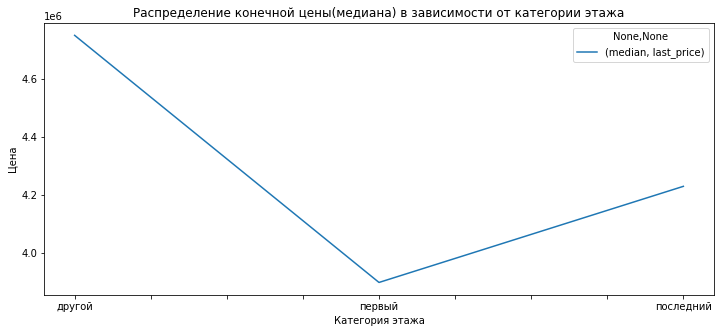

In [43]:
data.pivot_table(index = 'floor_category' , values = 'last_price' , aggfunc = ['median']).plot(style = '-', figsize=(12, 5))
plt.title("Распределение конечной цены(медиана) в зависимости от категории этажа")
plt.ylabel("Цена")
plt.xlabel("Категория этажа")
plt.show()

In [44]:
data.pivot_table(index = 'floor_category' , values = 'last_price' , aggfunc = ['median'])

,median
,last_price
floor_category,
другой,4750000.0
первый,3899000.0
последний,4230000.0


Медианная цена для первого этажа заметно ниже медианной цены для последнего. Похоже, люди предпочитают жить повыше.

(0.0, 250.0)

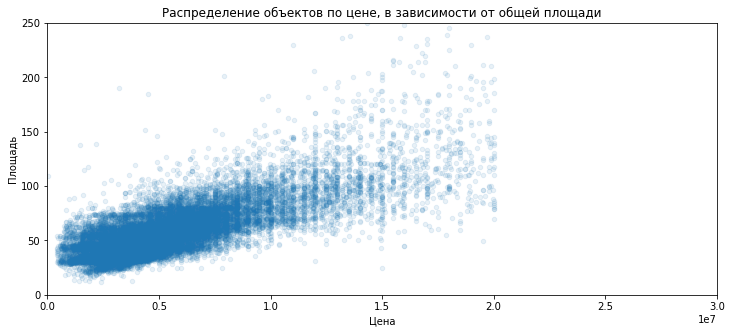

In [45]:
data.plot(x='last_price', y='total_area', kind='scatter' , alpha = 0.1 , figsize=(12, 5)) 
plt.title("Распределение объектов по цене, в зависимости от общей площади")
plt.ylabel("Площадь")
plt.xlabel("Цена")
plt.xlim((0,30000000))
plt.ylim((0,250))

(0.0, 100.0)

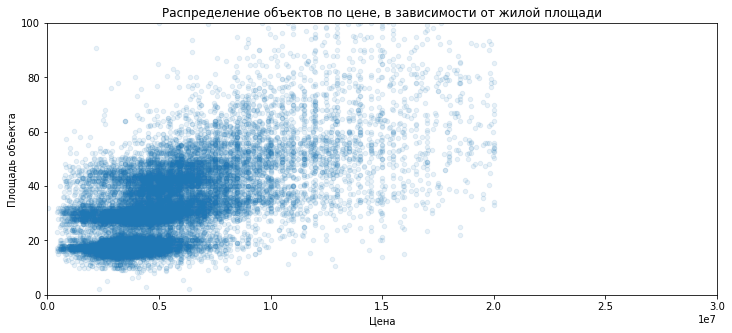

In [46]:
data.plot(x='last_price', y='living_area', kind='scatter' , alpha = 0.1 , figsize=(12, 5))
plt.title("Распределение объектов по цене, в зависимости от жилой площади")
plt.ylabel("Площадь объекта")
plt.xlabel("Цена")
plt.xlim((0,30000000))
plt.ylim((0,100))

(0.0, 250.0)

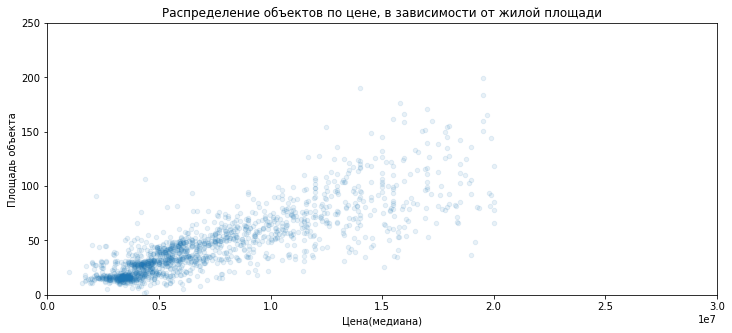

In [47]:
liv_price = data.pivot_table(index = 'living_area' , values = 'last_price' , aggfunc= 'median').reset_index()
liv_price.columns = ['living_area','last_price']
liv_price.plot(x='last_price' , y='living_area', kind='scatter' , alpha = 0.1 , figsize=(12, 5))

plt.title("Распределение объектов по цене, в зависимости от жилой площади")
plt.ylabel("Площадь объекта")
plt.xlabel("Цена(медиана)")

plt.xlim((0,30000000))
plt.ylim((0,250))

(0.0, 250.0)

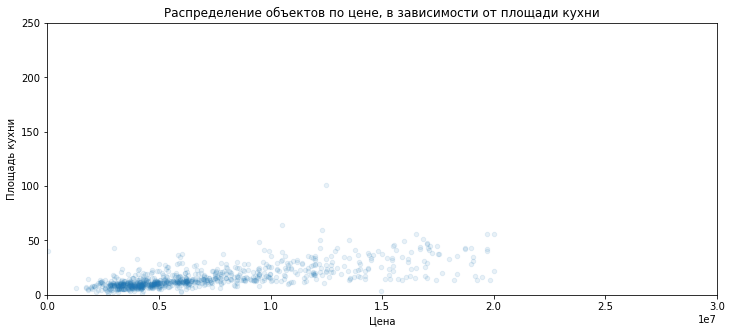

In [48]:
kit_price = data.pivot_table(index = 'kitchen_area' , values = 'last_price' , aggfunc= 'median').reset_index()
kit_price.columns = ['kitchen_area','last_price']
kit_price.plot(x='last_price' , y='kitchen_area', kind='scatter' , alpha = 0.1 , figsize=(12, 5))
plt.title("Распределение объектов по цене, в зависимости от площади кухни")
plt.ylabel("Площадь кухни")
plt.xlabel("Цена")
plt.xlim((0,30000000))
plt.ylim((0,250))

(0.0, 20000000.0)

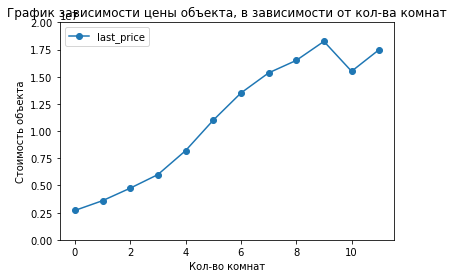

In [49]:
room_price = data.pivot_table(index = 'rooms' , values = 'last_price' , aggfunc= 'median').reset_index()
room_price.columns = ['rooms','last_price']
room_price.plot(x='rooms' , y='last_price', style='o-')
plt.title("График зависимости цены объекта, в зависимости от кол-ва комнат")
plt.ylabel("Стоимость объекта")
plt.xlabel("Кол-во комнат")
plt.ylim((0,20000000))

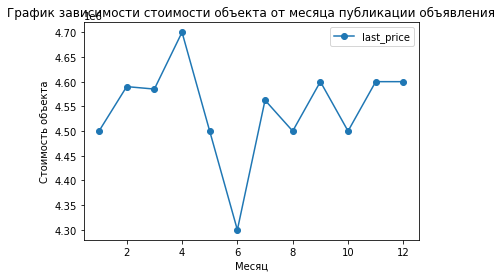

In [50]:
month_price = data.pivot_table(index = 'month' , values = 'last_price' , aggfunc= 'median').reset_index()
month_price.columns = ['month','last_price']
month_price.plot(x='month' , y='last_price', style='o-')
plt.title("График зависимости стоимости объекта от месяца публикации объявления")
plt.ylabel("Стоимость объекта")
plt.xlabel("Месяц")
plt.show()

Общая площадь квартиры оказывает наибольший эффект на стоимость квартиры. Это показывает коэффицент корреляции и график, который мы построили на основе наших данных. 
Коэффиценты корреляции по дням, месяцам,годам ближе к 0, это говорит о об отсутствии зависимости этих данных.


In [51]:
# Создаем сводную таблицу по Локальному названию и цене за 1 кв м ,сортируем по убыванию и переименовываем названия столбцов
price_by_ln = data.pivot_table(index='locality_name' , values='price_per_q' , aggfunc='mean').sort_values('price_per_q', ascending = False).round(0).reset_index()
price_by_ln.columns=['locality_name' , 'price_per_q_mean']
price_by_ln.head()

,locality_name,price_per_q_mean
0,Санкт-Петербург,108683.0
1,Зеленогорск,106044.0
2,Пушкин,101789.0
3,Сестрорецк,101331.0
4,поселок Лисий Нос,100661.0


In [52]:
# Создаем список с наибольшим кол-вом объявлений
top10_by_count = data.pivot_table(index='locality_name', values='price_per_q', aggfunc='count').sort_values('price_per_q' , ascending=False)

In [53]:
# Объединяем две таблицы, чтобы подтянуть к топ 10 Местности стоимость 1 кв метра
top10_price_per = top10_by_count.merge(price_by_ln , left_on = 'locality_name' , right_on='locality_name')
top10_price_per.columns=['locality_name' , 'count' , 'price_per_q_mean']
top10_price_per.head()

,locality_name,count,price_per_q_mean
0,Санкт-Петербург,15033,108683.0
1,поселок Мурино,556,85682.0
2,поселок Шушары,440,78677.0
3,Всеволожск,397,67214.0
4,Пушкин,360,101789.0


In [54]:
# Топ 5 по стоимости квадратного метра
price_by_ln[:5]

,locality_name,price_per_q_mean
0,Санкт-Петербург,108683.0
1,Зеленогорск,106044.0
2,Пушкин,101789.0
3,Сестрорецк,101331.0
4,поселок Лисий Нос,100661.0


In [55]:
# Список населенных пунктов с нименьшей стоимостью квадратного метра
price_by_ln[-5:]

,locality_name,price_per_q_mean
314,поселок Совхозный,12629.0
315,деревня Выскатка,12335.0
316,деревня Вахнова Кара,11688.0
317,поселок Свирь,11481.0
318,деревня Старополье,11206.0


Петербург оказался с самым высоким показателем стоимости квадратного метра. Это неудивительно для второй столицы.
В антирейтинге стоимости квадратного метра Старополье. Разница с Петербургом почти в 10 раз.

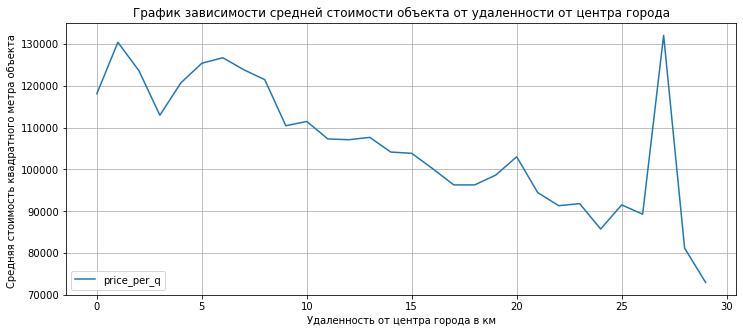

In [56]:
(
    data.query('locality_name == "Санкт-Петербург"')
    .pivot_table(index='cityCenters_nearest' , values='price_per_q' , aggfunc='mean')
    .plot(grid=True , figsize = (12,5))

)

plt.title("График зависимости средней стоимости объекта от удаленности от центра города")
plt.ylabel("Средняя стоимость квадратного метра объекта ")
plt.xlabel("Удаленность от центра города в км")


plt.show()

По мере удаления от центра города средняя цена за квадратный метр заметно снижается. Стоит обратить внимание на пиковые значения на расстоянии 5 км ( Возможно это Петроградский район - второй центр города) а так же на 25-30 км (уже похоже на премиум загородную недвижимость)

### Общий вывод

Категоризация данных позволяет говорить, о том что жители СПб и ЛО ценят последний этаж больше чем первый. Медианная цена для первого этажа 3899000.0 а для последнего 4230000.0
    Как мы видим, спустя 90 дней новый объект находит своего покупателя чаще всего, это же подтверждает медианное значени : 94 дня. Тем не менее, большое кол-во объявлений остаются актуальными и год и два.
    Нам так же удалось выделить топ 5 самых населенных пунктов по стоимости квадратного метра, ими стали : Санкт-Петербург,Зеленогорск,Пушкин,Сестрорецк и Лисий нос. Антирейтинг по стоимости квадратного метра возглавляет поселок Совхозный.
    По мере удаления от центра города стоимость квадратного метра заметно падает, но в городе так же есть  и дорогая загородная недвижимость.
Данные действительно реалистичны, это говорит о корректности проведенного анализа.